Hunter Bennett | Glass Lab | Brain Aging Project | 12 Feb 2021 


This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks and compares paiwised between groups. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [8]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [17]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_atac_peaks_all.txt')

Select best samples if annotation or QC step revealed outliers.

In [18]:
best_reps = ['03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC',
       '07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA']

In [20]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_atac_peaks_all.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_atac_peaks_all_samples_filtered.txt', sep='\t')

In [ ]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_kc_control_atac_peaks_filtered.txt \
# 00_microglia_4months 00_microglia_4months 00_microglia_4months 00_microglia_4months \
# 01_microglia_25months 01_microglia_25months 01_microglia_25months \
# -peaks > ./merged_peaks/diff_output.txt

### Import differential peaks

In [21]:
drop_files = ['/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_1_AL_20191226_ATTCCT',
              '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2D_JOS_20191122_CTTGTA',
              '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2_AL_20191122_CTTGTA',
              '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_23month_PU1_ChIP_H3K27ac_1_AL_20201121_ATGTAAGT_ACTCTATG',
              '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_28month_PU1_ChIP_H3K27ac_1_AL_20201121_AACGTTCC_GGAGTACT']

In [23]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_atac_peaks_all.txt')

annotatePeaks all peaks (119988, 30)
getDiffExpression selected transcripts (105085, 28)
annotatePeaks selected peaks (105085, 30)


In [24]:
diff_peak = diff_peak.loc[:, ~diff_peak.columns.str.contains('|'.join(drop_files))]
peaks = peaks.loc[:, ~peaks.columns.str.contains('|'.join(drop_files))]
peak_mat = peak_mat.loc[:, ~peak_mat.columns.str.contains('|'.join(drop_files))]
peak_mat_quant = peak_mat_quant.loc[:, ~peak_mat_quant.columns.str.contains('|'.join(drop_files))]

In [25]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [26]:
comps = ['00_microglia_4months vs. 01_microglia_25months']

groups = [[[0,1,2,3],
         [4,5,6]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#6baed6', '#3182bd']]

00_microglia_4months vs. 01_microglia_25months
N peaks down 668
N peaks up 1467



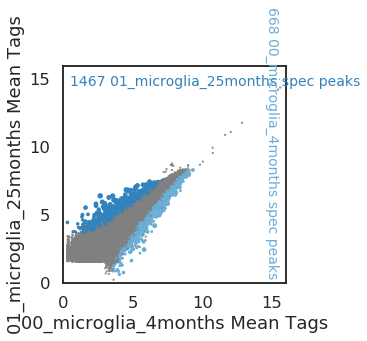

In [27]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N peaks down', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N peaks up', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,14.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(14.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Cluster differential enhancers:

### all enhancers

440


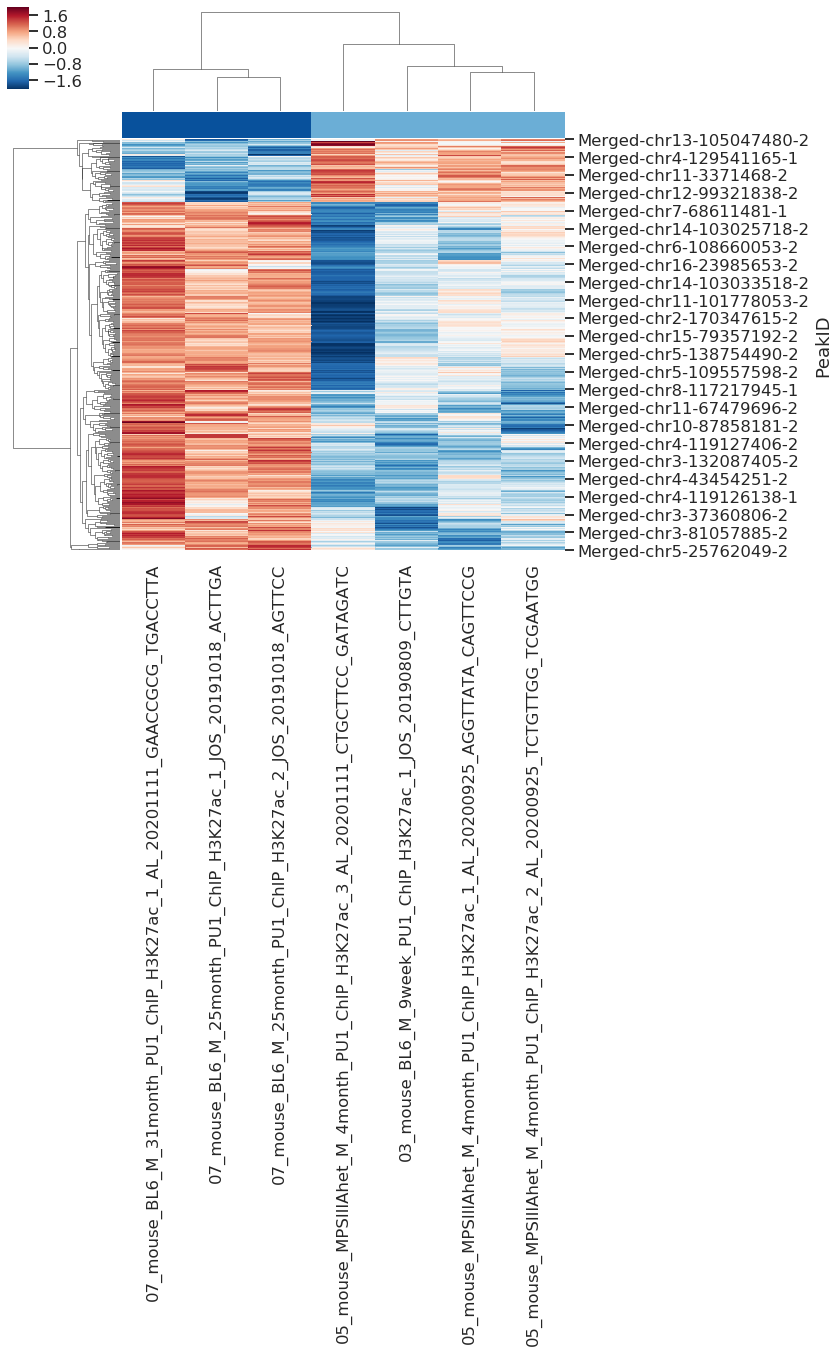

In [28]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#6baed6', '#6baed6','#6baed6', '#6baed6',
                           '#08519c', '#08519c', '#08519c'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

1580


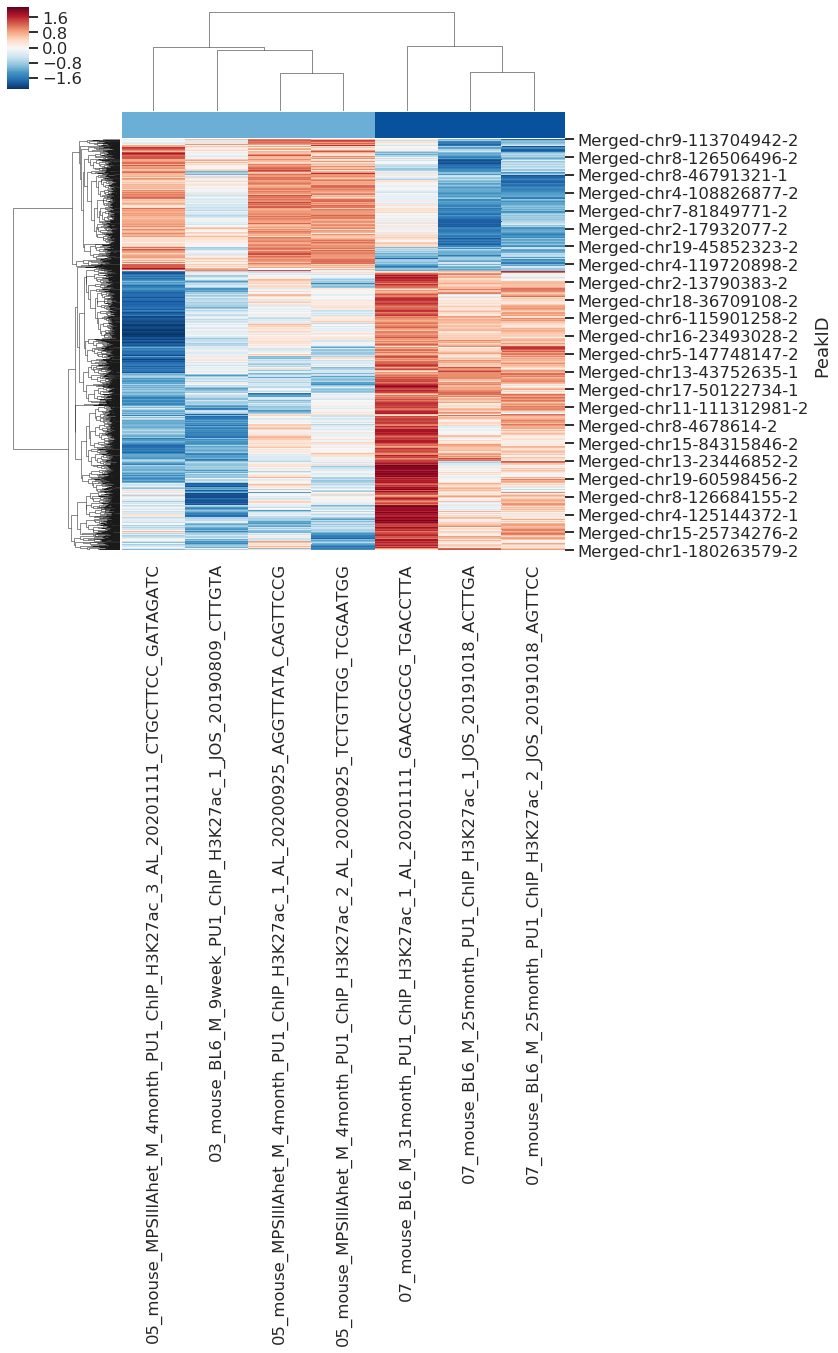

In [29]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#6baed6', '#6baed6','#6baed6', '#6baed6',
                           '#08519c', '#08519c', '#08519c'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [15]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [16]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_c57',
         '01_balbc',
         '02_aj']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_c57 ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 3777 peaks
Intersection set at: 3777 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 4864 peaks
Intersection set at: 1927 peaks

2
For comp: 01_balbc vs. 02_aj
Union set at: 4864 peaks
Intersection set at: 1927 peaks

Analyzing 01_balbc ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 2725 peaks
Intersection set at: 2725 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 2725 peaks
Intersection set at: 2725 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 3325 peaks
Intersection set at: 517 peaks

Analyzing 02_aj ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 3325 peaks
Intersection set at: 517 peaks

0
For comp: 00_c57 vs. 02_aj
Union set at: 2248 peaks
Intersection set at: 2248 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 3208 peaks
Intersection set at: 249 peaks



### For annotated peaks we want to pull the peak locations from the original merged ATAC-seq file

In [17]:
atac_peaks = pd.read_csv('./merged_peaks/idr_peaks_merged.txt', sep='\t', index_col=0)

In [18]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [19]:
convert_dict = {'start': int,
                'end': int}

In [20]:
for key in peak_lists.keys():
    # save cell specific promoters
    tmp = atac_peaks_200bp.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks.txt',
               sep='\t')
        

Save full set of peaks for background

In [21]:
atac_peaks_200bp.iloc[:, :4].to_csv(
    './great_analysis/peak_files/all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [22]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

rm: cannot remove ‘./peak_to_bed_great.sh’: No such file or directory


In [23]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [24]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [25]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [26]:
!ls ./bed_files/

00_c57_intersection_act_peaks.bed    02_aj_intersection_act_peaks.bed
00_c57_union_act_peaks.bed	     02_aj_union_act_peaks.bed
01_balbc_intersection_act_peaks.bed  all_peaks.bed
01_balbc_union_act_peaks.bed


### label for uploading to UCSC

In [27]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*act_peaks.bed*'):

        strain = i.split('/')[-1].split('_')[1]
        settype = i.split('/')[-1].split('_')[2]
        group = "AMLN_30weeks"
        chip = 'H3K27Ac'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_%s\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)
        lab_dist = "'track name=\"%s_%s_%s_%s_distal\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [28]:
%%bash

echo 'track name="kupffer_control_amln_30weeks_merged" description="Kupffer AMLN 30weeks ATAC All Strains"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check bed files and peaks in browser

In [30]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [31]:
diff_peak.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU

In [32]:
diff_peak.sort_values('00_microglia_4months vs. 01_microglia_25months adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA,00_microglia_4months vs. 01_microglia_25months Log2 Fold Change,00_microglia_4months vs. 01_microglia_25months p-value,00_microglia_4months vs. 01_microglia_25months adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr5-95935198-2,chr5,95934691,95935691,+,1000.000000,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,-21748.0,NM_018866,...,5.899465,5.929252,6.096782,7.369899,7.402135,7.266869,2.102610,1.012419e-20,4.946712e-16,chr5:95934691-95935691
Merged-chr5-95942787-2,chr5,95942291,95943291,+,1000.000000,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,-14148.0,NM_018866,...,5.503192,5.369716,5.569992,7.280516,7.370191,6.727738,2.476271,1.292515e-20,4.946712e-16,chr5:95942291-95943291
Merged-chr4-128002820-1,chr4,128002320,128003320,+,1000.000000,./atac_peak_files/microglia_25months.idr,"intron (NM_001281955, intron 1 of 70)","intron (NM_001281955, intron 1 of 70)",14776.0,NM_001281955,...,4.192037,4.583032,4.283953,6.068868,6.119040,6.542577,3.895806,3.490851e-20,6.680093e-16,chr4:128002320-128003320
Merged-chr5-95941891-2,chr5,95941409,95942409,+,819.419678,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,-15030.0,NM_018866,...,5.721040,5.283519,5.302070,7.032350,7.107678,6.993982,2.679072,2.675904e-20,6.680093e-16,chr5:95941409-95942409
Merged-chr5-95898136-2,chr5,95897632,95898632,+,844.087524,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,-58807.0,NM_018866,...,5.598256,5.591712,5.428914,6.854825,6.977310,7.020889,2.228387,2.328968e-19,3.565370e-15,chr5:95897632-95898632
Merged-chr1-94052564-1,chr1,94052064,94053064,+,819.166687,./atac_peak_files/microglia_25months.idr,promoter-TSS (NM_008798),promoter-TSS (NM_008798),-11.0,NM_008798,...,4.630729,4.664323,4.877873,6.227273,6.636302,6.481955,2.993998,3.380841e-19,4.313051e-15,chr1:94052064-94053064
Merged-chr5-95914204-2,chr5,95913710,95914710,+,975.000000,./atac_peak_files/microglia_25months.idr|./ata...,Intergenic,Intergenic,-42729.0,NM_018866,...,4.323053,4.140146,4.546579,6.188255,6.230211,5.640375,3.583784,1.051258e-17,1.149536e-13,chr5:95913710-95914710
Merged-chr12-71886029-2,chr12,71885520,71886520,+,892.087524,./atac_peak_files/microglia_25months.idr|./ata...,"intron (NM_026102, intron 1 of 25)","intron (NM_026102, intron 1 of 25)",-3523.0,NM_001286452,...,6.024595,5.897314,5.568767,7.160354,7.285283,7.063301,1.989612,2.923633e-17,2.797332e-13,chr12:71885520-71886520
Merged-chr19-29487591-1,chr19,29487091,29488091,+,645.500000,./atac_peak_files/microglia_25months.idr,Intergenic,Intergenic,34396.0,NR_015567,...,6.603556,6.762911,6.881401,7.918393,7.802100,7.821068,1.426683,6.309136e-17,5.365850e-13,chr19:29487091-29488091
